# Develop lstm model for time series prediction

In [1]:
# interactive figures
%matplotlib widget 

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# time series pipeline
from one_dimensional_time_series_forecasting import time_series_prediction, hit_rate

# model evalution metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# data preprocessing
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split

# predictive models
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from sklearn.neural_network import MLPRegressor

# keras stuff
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import keras
import tensorflow

2022-05-11 15:10:04.468662: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-11 15:10:04.468715: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


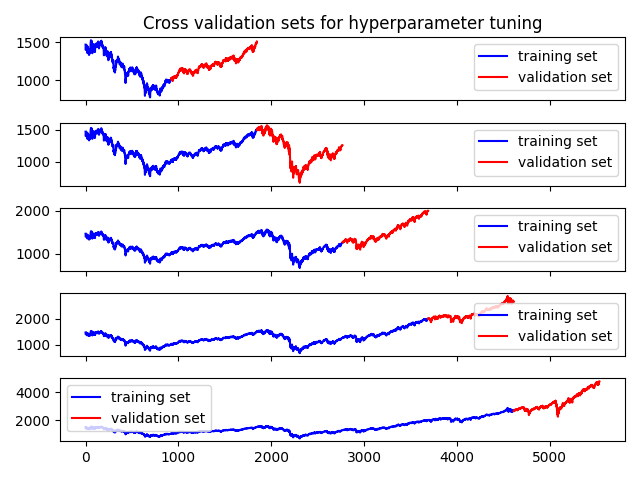

Training multivariate linear regression:

Linear regression coefficients: 
 [1.00079372]
MAPE: 0.0022008203471515233
RMSE:  12.531798111401747
MAE:  10.522682437119784

Training LSTM neural network: 
Epoch 1/2000
44/44 [==============================] - 1s 3ms/step - loss: 2862399.5000
Epoch 2/2000
44/44 [==============================] - 0s 3ms/step - loss: 43316.1367
Epoch 3/2000
44/44 [==============================] - 0s 3ms/step - loss: 1066.3540
Epoch 4/2000
44/44 [==============================] - 0s 3ms/step - loss: 477.0814
Epoch 5/2000
44/44 [==============================] - 0s 3ms/step - loss: 471.1360
Epoch 6/2000
44/44 [==============================] - 0s 3ms/step - loss: 471.2458
Epoch 7/2000
44/44 [==============================] - 0s 3ms/step - loss: 470.6407
Epoch 8/2000
44/44 [==============================] - 0s 4ms/step - loss: 470.1973
Epoch 9/2000
44/44 [==============================] - 0s 3ms/step - loss: 471.3404
Epoch 10/2000
44/44 [=========================

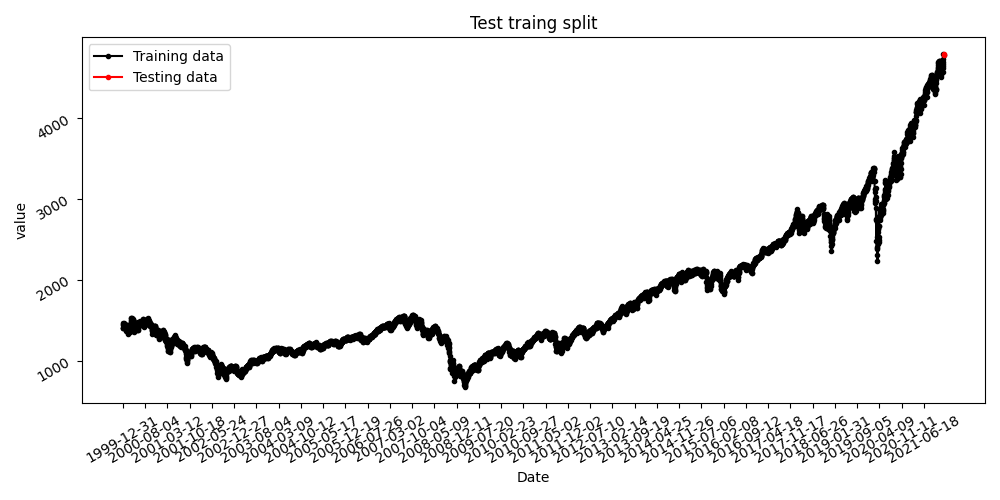

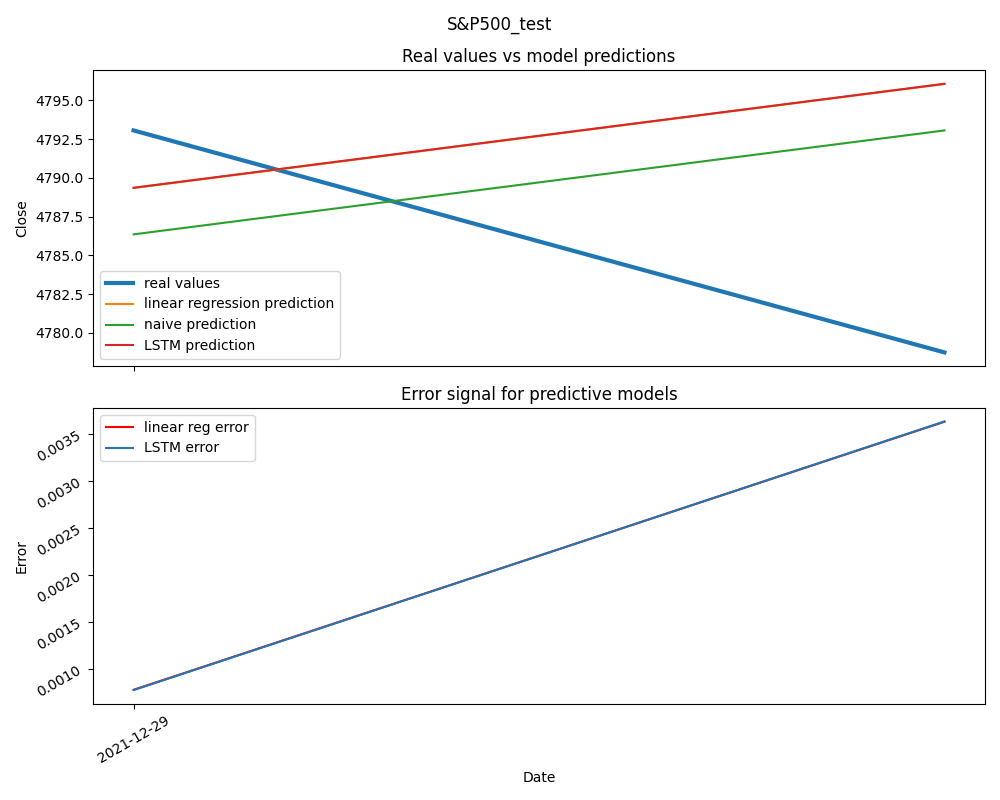

In [3]:
########################################################################
# data
########################################################################
df = pd.read_csv('./test_data/S&P500_yfinance.csv')
x = df['Close'][-40:]
dates = df['Date'][-40:]

# percentage returns
x_pct = x.pct_change().fillna(0)
x_pct

# create new df hold both
# df = pd.DataFrame(columns=['Dates','Open','pct_change','pct_change_cumprod']) # ,'log_transform'
# df['Month'] = dates
# df['Volume'] =  x
# df['pct_change'] = x_pct
# df['pct_change_cumprod'] = (x_pct + 1).cumprod()

########################################################################
# initialize class object
########################################################################
normal = time_series_prediction('S&P500','test',df['Date'],df['Close'],1,1) # pass time series, lag window length, a number of steps ahead to predict
normal.sliding_window_1(verbose=0) # time series to supervised learning ML problem
normal.train_test_split(split=2) # testing and training dataset split
normal.test_train_plot()    # visualize training split

########################################################################
# perform some prediction tasks
########################################################################
normal.linear_regression()
# normal.support_vector_machine()
# normal.neural_net_mlp()
normal.lstm(model_tunning=False)
normal.naive_model()

normal.vis_results_time_series(second_plot='error',ylabel='Close')

# Build LSTM

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt


In [ ]:
def lstm(n_input, n_nodes, n_lstm_layers, n_epochs, n_batch, train_x, train_y,verbose=1):

    """
    This function trains a keras lstm neural network. Some important parameters are:

    :param n_input: the lag number
    :param n_nodes: number of hidden units - list with number of nodes per lstm layer
    :param n_lstm_layers: number of lstm hidden layers
    :param n_epochs: number of times training passes over the entire training set
    :param n_batch: how many training samples before weights are updated
    """

    # define model
    model = Sequential()
    
    # add initial lstm layers
    model.add(LSTM(n_nodes[0], activation= 'relu' , input_shape=(n_input, 1),return_sequences=True)) # lstm layer

    # add subsequent hidden LSTM layers
    if n_lstm_layers > 1:
        # setup hidden layers between first and last LSTM layers
        for i in range(1,n_lstm_layers-1):
            model.add(LSTM(n_nodes[i], activation= 'relu', return_sequences=True))

        # add final lstm hidden layers
        model.add(LSTM(n_nodes[i+1], activation= 'relu', return_sequences=False))

    # add a final fully connected layer + single predictor layer 
    model.add(Dense(1))                                                    # final predictor

    # prepare optimizer and compile model
    opt = Adam(learning_rate=0.001)
    model.compile(loss= 'mse', optimizer= opt)

    # setup some callbacks
    callbacks_list = [EarlyStopping(verbose=1,monitor='loss',mode='min',patience=20)]

    # fit model
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=verbose, callbacks=callbacks_list)

    # show model summary
    model.summary()

    return model

In [ ]:
# get data from time series prediction object

x_train = normal.X_train
y_train = normal.y_train

x_test = normal.X_test
y_test = normal.y_test


# fit model
model = lstm(
            n_input=10, 
            n_nodes=[112,112,16,112], 
            n_lstm_layers=4, # this is the number of layers specififed in n_nodes ie len(n_nodes)
            n_epochs=1000, 
            n_batch=128,
            train_x=x_train, 
            train_y=y_train,
            verbose=1)

# predict test set
yhat = model.predict(x_test, verbose=0)

# calculate root mean squared error
testScore = math.sqrt(mean_squared_error(y_test, yhat))
print('Test Score: %.2f RMSE' % (testScore))
mae = mean_absolute_error(y_test, yhat)
print('MAE: ',mae)


In [ ]:
# predict test set
yhat = model.predict(x_test, verbose=0)

# calculate root mean squared error
testScore = math.sqrt(mean_squared_error(y_test, yhat))
print('Test Score: %.2f RMSE' % (testScore))
mae = mean_absolute_error(y_test, yhat)
print('MAE: ',mae)

In [ ]:
tensorflow.keras.utils.plot_model(
    model,
    to_file='./model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='LR',
    expand_nested=True,
    dpi=96,
    layer_range=None,
    show_layer_activations=True
)

In [ ]:
feat_engineer = 'minmax'
financial_asset = 'S&P500'

""" 
Build LSTM hyperparemeter tuner 

Following this guide: https://keras.io/guides/keras_tuner/getting_started/
"""
def build_model(hp):

    # define model
    model = Sequential()
    
    # add initial lstm layers
    model.add(LSTM(units=hp.Int("units 0", min_value=16, max_value=288, step=32), activation= 'relu' , input_shape=(10, 1),return_sequences=True)) # lstm layer

    # setup hidden layers between first and last LSTM layers
    for i in range(hp.Int('layers',1,3)):
        model.add(LSTM(hp.Int(f"units {i}", min_value=16, max_value=288, step=32), activation= 'relu', return_sequences=True))

    # add final lstm hidden layers
    model.add(LSTM(hp.Int("units -1", min_value=16, max_value=288, step=32), activation= 'relu', return_sequences=False))

    # add a final fully connected layer + single predictor layer 
    model.add(Dense(1))                                                    # final predictor

    # prepare optimizer and compile model
    opt = Adam(learning_rate=hp.Choice('learning_rate',[1e-2,1e-3,1e-4]))
    model.compile(loss= 'mse', optimizer= opt)

    return model

# setup hyperparameter tuner
tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective="val_loss",
    max_trials=3,
    executions_per_trial=1,
    overwrite=True,
    directory=f"./results/univariate_single_step_ahead/{feat_engineer}/{financial_asset}/LSTM_training",
    project_name="training_my_lstm",
)

# setup data with validation set for hp tuning
X_train = x_train
Y_train = y_train

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=1, shuffle=False)

# start tuning hyperparameters
tuner.search(X_train, Y_train, epochs=5, validation_data=(X_val, Y_val))

# save best hyperparamters



In [ ]:
len(tuner.get_best_models())

In [ ]:
import sys
from io import StringIO

s = StringIO()

sys.stdout = s
tuner.results_summary()

sys.stdout = sys.__stdout__


In [ ]:
best_hp = tuner.get_best_hyperparameters(1)
best_hp[0].get('helloworld')

In [ ]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None, 10, 1))
best_model.summary()

In [ ]:
models = tuner.get_best_models(num_models=2)

In [ ]:
models[0]

In [ ]:
# use best model

x_train = normal.X_train
y_train = normal.y_train

x_test = normal.X_test
y_test = normal.y_test

# setup retraining callbacks
callbacks_list = [EarlyStopping(verbose=1,monitor='loss',mode='min',patience=20)]

# retrieve and build best LSTM model
best_hp = tuner.get_best_hyperparameters(1)
model = build_model(best_hp[0])
history = model.fit(x_train, y_train, epochs=1000, batch_size=128, verbose=1, callbacks=callbacks_list)

# test set preidictions
lstm_predictions = model.predict(x_test)
lstm_predictions = np.ravel(lstm_predictions[:,0])

# retrain best model to get training history
history = best_model.fit(x_train,y_train,epochs=10)

# predict test set
yhat = best_model.predict(x_test, verbose=0)

# calculate root mean squared error
testScore = math.sqrt(mean_squared_error(y_test, yhat))
print('Test Score: %.2f RMSE' % (testScore))
mae = mean_absolute_error(y_test, yhat)
print('MAE: ',mae)

In [ ]:
history

In [ ]:
history.loss_curve_

# lets test LSTM model from time series module

In [ ]:
from one_dimensional_time_series_forecasting import time_series_prediction

In [ ]:
# import some data
df = pd.read_csv('./test_data/GSPC.csv') # sp_500 = GSPC.csv, # airplaine = AirPassengers.csv
df = df.iloc[-2000:,:].reset_index(drop=True) # only look at last 2000 days
df.drop(labels='Adj Close',axis=1,inplace=True)
# df.plot(figsize=(10,16),legend=True,xlabel='Month',subplots=True,x='Date')
plt.tight_layout()
# display(df)

In [ ]:
# some forecasting parameters
window_length = 10
split = 500

# scale input data
scaler = MinMaxScaler()
test_data_scaler = scaler.fit(df['Open'].iloc[0:-split].to_numpy().reshape(-1,1))#.flatten()
scaled_training_data = scaler.fit_transform(df['Open'][0:-split].to_numpy().reshape(-1,1))#.flatten()
scaled_test_data = scaler.transform(df['Open'][-split:].to_numpy().reshape(-1,1))#.flatten()
scaled_data = np.append(scaled_training_data,scaled_test_data)

# initialize class object
blah = time_series_prediction(df['Date'],scaled_data,window_length,1)#time_series_prediction(sp_500['Date'][-4000:],sp_500['Volume'][-4000:]/1e9,5,1) # pass: ime series dates, univariate time series, lag window length, a number of steps ahead to predict
blah.sliding_window_1(verbose=0) # time series to supervised ML problem
blah.train_test_split(split=split) # testing and training dataset split
blah.test_train_plot(ylabel='Open price')    # visualize training split

# perform some prediction tasks
blah.linear_regression()
blah.support_vector_machine(model_tunning=True)
blah.neural_net_mlp(model_tunning=True)
blah.lstm(model_tunning=True)
blah.naive_model()

# visualize results
blah.vis_results_time_series(ylabel='Open price',second_plot='error')

# tabulate results
tabulated_results_0 = blah.results()
tabulated_results_0.plot()
display(tabulated_results_0)

In [ ]:
blah.vis_results_time_series(ylabel='Open price',second_plot='error')


In [ ]:
blah.lstm_predictions.flatten()

In [ ]:
blah.linear_reg_predictions